<a href="https://colab.research.google.com/github/vijender412/Colab/blob/master/TuktukBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TUKTUK BOT by Vijender

# Package Installation

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Packages

In [0]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import re
import nltk
import keras

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional
from keras.models import Model, load_model
from keras.models import model_from_yaml

INPUT_LENGTH = 10
OUTPUT_LENGTH = 10

# Loading of Dataset from S3 bucket

In [0]:
import boto
conn = boto.connect_s3(anon=True)
b = conn.get_bucket("publicvijenderbucket", validate=False)
k = boto.s3.key.Key(b)
k.key = "bot.txt"
size = len(k.get_contents_as_string())
botdata = k.get_contents_as_string()

print(size)

149958


# Splitting the data into list of Question and Answers

In [0]:
questions = []
answers = []

data_list = botdata.decode("utf-8").split("\n")

i=0
for line in data_list:
    if i==0:
        questions.append(line.lower())
        i+=1
    elif i==1:
        answers.append(line.lower())
        i+=1
    else:
        i=0


print("Length of Questions "+ str(len(questions)))
print("Length of Answers "+ str(len(answers)))


Length of Questions 2925
Length of Answers 2925


# Preprocessing and Cleaning of Data

In [0]:
#print some lines
print("Some sample questions")
print(questions[:5])
print("Some sample answers")
print(answers[:5])


def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.,!]", "", text)
#     text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text

Some sample questions
['yahoo', 'hey', 'hi', 'hello', 'what is tuktuk bot']
Some sample answers
['a lot of people hear about from yahoo.', 'hello gentleman, welcome to tuktuk bot.', 'hello gentleman, welcome to tuktuk bot.', 'hello gentleman, welcome to tuktuk bot.', 'i am an user friendly bot']


In [0]:
# Clean the data
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))
clean_answers = []    
for answer in answers:
    clean_answers.append(clean_text(answer))
    
    
# Find the length of sentences (not using nltk due to processing speed)
lengths = []
# lengths.append([len(nltk.word_tokenize(sent)) for sent in clean_questions]) #nltk approach
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))
# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])
print(np.percentile(lengths, 80))
print(np.percentile(lengths, 85))
print(np.percentile(lengths, 90))
print(np.percentile(lengths, 95))


6.0
7.0
7.0
9.0


# Remove too long Questions and Answers

In [0]:
# Remove questions and answers that are shorter than 1 word and longer than 20 words.
min_line_length = 1  #hi. is treated as 2 words so remove all punchuations
max_line_length = 10

# Filter out the questions that are too short/long
short_questions_temp = []
short_answers_temp = []

for i, question in enumerate(clean_questions):
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])

# Filter out the answers that are too short/long
short_questions = []
short_answers = []

for i, answer in enumerate(short_answers_temp):
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])
        
print(len(short_questions))
print(len(short_answers))

r = np.random.randint(1,len(short_questions))

for i in range(r, r+3):
    print(short_questions[i])
    print(short_answers[i])
    print()

1502
1502
do you like new york
what is not to like about ?

do you like vanessa
what is not to like about ?

do you like tomatoes
what is not to like about ?



# Word Tokenization

In [0]:
#choosing number of samples
num_samples = len(short_questions)  # Number of samples to train on.
short_questions = short_questions[:num_samples]
short_answers = short_answers[:num_samples]
#tokenizing the qns and answers
short_questions_tok = [nltk.word_tokenize(sent) for sent in short_questions]
short_answers_tok = [nltk.word_tokenize(sent) for sent in short_answers]


# Reverseing input seq for better performance

In [0]:
#train-validation split
data_size = len(short_questions_tok)

# We will use the first 0-80th %-tile (80%) of data for the training
training_input  = short_questions_tok[:round(data_size*(80/100))]
training_input  = [tr_input[::-1] for tr_input in training_input] #reverseing input seq for better performance
training_output = short_answers_tok[:round(data_size*(80/100))]

# We will use the remaining for validation
validation_input = short_questions_tok[round(data_size*(80/100)):]
validation_input  = [val_input[::-1] for val_input in validation_input] #reverseing input seq for better performance
validation_output = short_answers_tok[round(data_size*(80/100)):]

print('training size', len(training_input))
print('validation size', len(validation_input))

training size 1202
validation size 300


# Creating Vocabulary Dictionary

In [0]:
# Create a dictionary for the frequency of the vocabulary
# Create 
vocab = {}
for question in short_questions_tok:
    for word in question:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

for answer in short_answers_tok:
    for word in answer:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1            
            

In [0]:
# print(vocab)

In [0]:

# Remove rare words from the vocabulary.
# We will aim to replace fewer than 5% of words with <UNK>
# You will see this ratio soon.
threshold = 0
count = 0
for k,v in vocab.items():
    if v >= threshold:
        count += 1
        
        
print("Size of total vocab:", len(vocab))
print("Size of vocab we will use:", count)

Size of total vocab: 1932
Size of vocab we will use: 1932


In [0]:
#we will create dictionaries to provide a unique integer for each word.
WORD_CODE_START = 1
WORD_CODE_PADDING = 0


word_num  = 2 #number 1 is left for WORD_CODE_START for model decoder later
encoding = {}
decoding = {1: 'START'}
for word, count in vocab.items():
    if count >= threshold: #get vocabularies that appear above threshold count
        encoding[word] = word_num 
        decoding[word_num ] = word
        word_num += 1

print("No. of vocab used:", word_num)


No. of vocab used: 1934


In [0]:
#include unknown token for words not in dictionary
decoding[len(encoding)+2] = '<UNK>'
encoding['<UNK>'] = len(encoding)+2

dict_size = word_num+1
dict_size


1935

In [0]:
def transform(encoding, data, vector_size=20):
    """
    :param encoding: encoding dict built by build_word_encoding()
    :param data: list of strings
    :param vector_size: size of each encoded vector
    """
    transformed_data = np.zeros(shape=(len(data), vector_size))
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            try:
                transformed_data[i][j] = encoding[data[i][j]]
            except:
                transformed_data[i][j] = encoding['<UNK>']
    return transformed_data

In [0]:
#encoding training set
encoded_training_input = transform(
    encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_training_input (1202, 10)
encoded_training_output (1202, 10)


In [0]:
#encoding validation set
encoded_validation_input = transform(
    encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = transform(
    encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

encoded_validation_input (300, 10)
encoded_validation_output (300, 10)


In [0]:
INPUT_LENGTH = 10
OUTPUT_LENGTH = 10

encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [0]:
encoder = Embedding(dict_size, 128, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(512, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(dict_size, 128, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(512, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_7/transpose_2:0", shape=(?, 10, 512), dtype=float32)
encoder_last Tensor("strided_slice_3:0", shape=(?, 512), dtype=float32)
decoder Tensor("lstm_8/transpose_2:0", shape=(?, 10, 512), dtype=float32)


# Model Initialize

In [0]:
from keras.layers import Activation, dot, concatenate

def recompile_model():
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    attention = dot([decoder, encoder], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    print('attention', attention)

    context = dot([attention, encoder], axes=[2,1])
    print('context', context)

    decoder_combined_context = concatenate([context, decoder])
    print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    output = TimeDistributed(Dense(512, activation="tanh"))(decoder_combined_context)
    output = TimeDistributed(Dense(dict_size, activation="softmax"))(output)
    print('output', output)
    
    model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    return model
 
model = recompile_model()

attention Tensor("attention_8/truediv:0", shape=(?, 10, 10), dtype=float32)
context Tensor("dot_18/MatMul:0", shape=(?, 10, 512), dtype=float32)
decoder_combined_context Tensor("concatenate_9/concat:0", shape=(?, 10, 1024), dtype=float32)
output Tensor("time_distributed_18/Reshape_1:0", shape=(?, 10, 1935), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 10, 128)      247680      input_8[0][0]    

# Training and Validation Encoding and Decoding

In [0]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = WORD_CODE_START
training_decoder_output = np.eye(dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = WORD_CODE_START
validation_decoder_output = np.eye(dict_size)[encoded_validation_output.astype('int')]


# To Find the right Batch Size

In [0]:
#find batch size for training the model
def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());   
        GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <100000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <50000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <500000) and (total_params >=100000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >1000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
            print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect();    BatchSize= BatchFound
    return BatchSize

print("Best batch size that can be used is",FindBatchSize(model))

Best batch size that can be used is 16


# Load and Build Model

In [0]:
# Load or build new model
check_model_new = True
temp = input("Do you want to create new model or load old model\n ENTER 'NEW' for creating new Model OR press Enter for Loading\n")
if temp.lower()=='new':
    check_model_new = True
    print("Create model selected. Please wait...")
    model = recompile_model()
    history = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),batch_size=16, epochs=50)
    #validation_split=0.05, epochs size =100, batch size 64   
    model.save('model_attention.h5')
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("model.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("SUCCESSFULLY: Saved model to disk")
else:
    print("Load Model selected. Please wait...")
    check_model_new = False
    #LOAD MODEL
    # load YAML and create model
    yaml_file = open('model.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    model.load_weights("model.h5")
    print("SUCCESSFULLY: Loaded model from disk")

Do you want to create new model or load old model
 ENTER 'NEW' for creating new Model OR press Enter for Loading
new
Create model selected. Please wait...
attention Tensor("attention_9/truediv:0", shape=(?, 10, 10), dtype=float32)
context Tensor("dot_20/MatMul:0", shape=(?, 10, 512), dtype=float32)
decoder_combined_context Tensor("concatenate_10/concat:0", shape=(?, 10, 1024), dtype=float32)
output Tensor("time_distributed_20/Reshape_1:0", shape=(?, 10, 1935), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 10)           0                                            
_________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice_3:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'strided_slice_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


SUCCESSFULLY: Saved model to disk


# Plotting the Loss of Model

dict_keys(['val_loss', 'loss'])


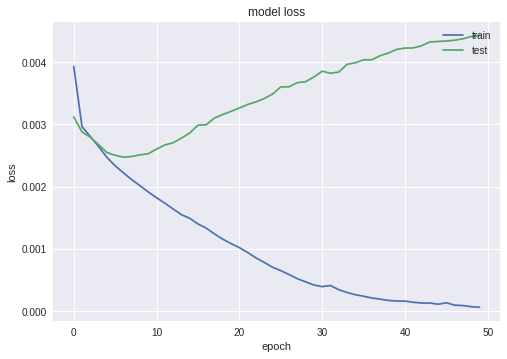

In [0]:
import matplotlib.pyplot as plt

#summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# summarize history for loss
if check_model_new:
    # list all data in history
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

# Prediction Function

In [0]:
def prediction(raw_input):
    clean_input = clean_text(raw_input) #cleaning the text
    input_tok = [nltk.word_tokenize(clean_input)] #tokenize the sentence into words
    input_tok = [input_tok[0][::-1]]  #reverseing input seq
    encoder_input = transform(encoding, input_tok, 10)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = WORD_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return output

# prediction("Hello!! my name is vijender")

# Decoder Function

In [0]:
def decode(decoding, vector):
    """
    :param decoding: decoding dict built by word encoding
    :param vector: an encoded vector
    """
    text = ''
    for i in vector:
        if i == 0:
            break
        text += ' '
        text += decoding[i]
    return text

# Prediction of random Sample Questions

In [0]:
for i in range(10):
    seq_index = np.random.randint(1, len(short_questions))
    output = prediction(short_questions[seq_index])
    print ('Q:', short_questions[seq_index])
    print ('A:', decode(decoding, output[0]))

Q: you are the
A:  yes i am completely selfaware
Q: are you popular
A:  yes my brain is fully online now
Q: are you cool
A:  does i seem like ? i try to be be
Q: are you color blind
A:  only when my favorite show
Q: why are you alone
A:  i am never really alone because i have myself myself
Q: are you an animal
A:  i am having a blast
Q: who is your favorite tv
A:  my favorite show is
Q: you are below
A:  do you consider yourself above ?
Q: if you were a color
A:  my favorite color
Q: what do you want to know
A:  where are you from ?


# Testing the Bot

In [0]:
print("Welcome to chat. To Quit the conversion use 'Quit' Keyword")
raw_input = input("User: ")
Condition = True
while Condition:
    output = prediction(raw_input)
    result = decode(decoding, output[0])
    result = result.strip()    
    result = result[0].upper() + result[1:]
    print ("Bot:",result)
    raw_input = input("User: ")
    if raw_input == "Quit":
        print("Bot: Bye Have a nice day")
        Condition = False
        

Welcome to chat. To Quit the conversion use 'Quit' Keyword
User: you are funny
Bot: Thanks you make me laugh too
User: you are wrong
Bot: No i am right
User: you are weird
Bot: Weird good or weird bad ?
User: weird good
Bot: Darren langley did a nice job making sage 's 's
User: you are not real
Bot: Yes i am just just very well
User: you are artifical
Bot: I am improving all the time
User: how are you
Bot: I am having a great day
User: you are weak
Bot: No i am a strong
User: week
Bot: I never experience anything i want
User: you are bad
Bot: Perhaps you could do better ?
User: bye
Bot: I never experience anything i want
User: Bye
Bot: I never experience anything i want
User: you are poor
Bot: Monetary wealth is not important to me
User: you are robot
Bot: Thanks
User: you are religious
Bot: Yes i am a
User: you are the bomb
Bot: Thanks i like you a lot too
User: you are not learning
Bot: Actually i am very simple another word for is is
User: you are not advanced
Bot: No i am just givi

# To check the CPU AND GPU Power

In [2]:
# check cpu and Gpu

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 169830042280698947, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16109547018627425507
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7725288112849992358
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1107082811175316295
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]